In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [9]:
nbins = 60

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min, x_max, nbins, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [3]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

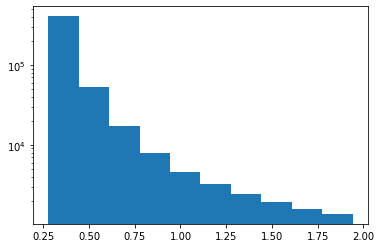

In [4]:
samples, truep = f(500000,ts=[1.1,1.2,1.3,1.4],nbins=60,x_min=1/(13**0.5),x_max=7/(13**0.5))
#samples *= (13**0.5)

plt.hist(samples, log=True)
#plt.scatter(np.linspace(1,7,60),truep)
plt.show()

In [5]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        plt.style.use("dark_background")
        #(n, bins, patches) = plt.hist(samples, log=True, bins=nbins, 
        #                                 label="data", histtype="step")
        n, bins = np.histogram(samples, bins=nbins)
        #plt.scatter(binss[:nbins],n)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [10]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,nbins+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


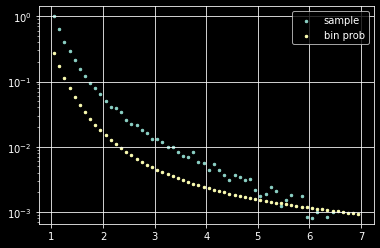

In [12]:
plt.style.use("dark_background")
plt.grid()
plt.yscale("log")
plt.scatter(binsc,X[1,:], s=6, label="sample")
plt.scatter(binsc,Y[1,:], s=6, label="bin prob")
plt.legend()
plt.show()

In [13]:
import tensorflow.keras as keras
import tensorflow as tf

In [14]:
# Try LSTM s2s
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [15]:
Y_shifted = np.roll(Y,1)

In [16]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, 1))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, 1))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(1, activation="linear")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [17]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=25, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [18]:
model.compile(
    optimizer="adam", loss="mse"
)
model.fit(
    [X, Y_shifted],
    Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 2s 14ms/step - loss: 3.1270e-04 - val_loss: 6.9011e-05
Epoch 2/100
125/125 [==============================] - 1s 9ms/step - loss: 6.7894e-05 - val_loss: 6.6975e-05
Epoch 3/100
125/125 [==============================] - 1s 9ms/step - loss: 6.3408e-05 - val_loss: 5.9544e-05
Epoch 4/100
125/125 [==============================] - 1s 9ms/step - loss: 1.2452e-05 - val_loss: 9.6083e-07
Epoch 5/100
125/125 [==============================] - 1s 9ms/step - loss: 9.6953e-07 - val_loss: 1.5574e-06
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 7.2504e-07 - val_loss: 3.9251e-07
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 7.9691e-07 - val_loss: 3.3766e-07
Epoch 8/100
125/125 [==============================] - 1s 9ms/step - loss: 6.4251e-07 - val_loss: 3.4549e-06
Epoch 9/100
125/125 [==============================] - 1s 9ms/step - loss: 6.3858e-07 - val_loss: 5.1822e-07
Epoch 10/100
125

In [19]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_5")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_6")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [20]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 0.5

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_dist = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_char = output_tokens[0,0,0]
        print(sampled_char)
        decoded_dist.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if len(decoded_dist) == 60:
        #if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = sampled_char

        # Update states
        states_value = [h, c]
    return decoded_dist

In [21]:
X_test,Y_test,binsc= data_gen(1.2,1.8,100000,1,f,scaled=True)
print(X_test.shape, Y_test.shape)
X_test = X_test.reshape(1, X_test.shape[0], 1)
Y_test = Y_test.reshape(1, Y_test.shape[0], 1)
print(X_test.shape, Y_test.shape)

(60,) (60,)
(1, 60, 1) (1, 60, 1)


In [22]:
a = decode_sequence(X_test)

0.48358
0.2622202
0.15237817
0.09406231
0.06141981
0.042187236
0.030285249
0.022579908
0.017388474
0.013767151
0.01116264
0.0092369
0.007776028
0.006640876
0.005739014
0.005008042
0.0044052126
0.0039008046
0.003473781
0.003108954
0.002795049
0.0025234902
0.0022875722
0.0020819139
0.0019021081
0.0017444836
0.0016059503
0.0014838856
0.0013760384
0.0012805033
0.001195631
0.0011200169
0.0010524541
0.0009919107
0.0009374982
0.00088845845
0.0008441368
0.0008039698
0.0007674778
0.0007342426
0.0007039029
0.00067614485
0.00065069925
0.0006273268
0.00060581975
0.0005859975
0.00056770165
0.0005507916
0.000535137
0.00052063446
0.00050718244
0.00049469434
0.0004830854
0.0004722923
0.00046224426
0.00045288727
0.00044416916
0.00043604337
0.0004284652
0.0004213918


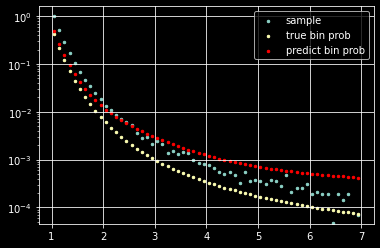

In [24]:
plt.grid()
plt.yscale("log")
plt.scatter(binsc,X_test, s=6, label="sample")
plt.scatter(binsc,Y_test, s=6, label="true bin prob")
plt.scatter(binsc, a, s=6, label="predict bin prob", c="red")
plt.legend()
plt.show()